## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

## And so on and so forth...

In [2]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import pickle


# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from PIL import Image, ImageFont, ImageDraw

#output of camera calibration
mtx = None
dist = None
first_frame = False
left_fit,right_fit = None,None


def convertImage(images,convertion_type):
    
    converted_images = []
    
    #This will return an image with only one color channel
    if(images is not None) and (len(images) > 0) and (convertion_type is not None): 
        if (type(images) is list):
            for image_item in images:
                converted_image = cv2.cvtColor(image_item,convertion_type)                
                converted_images.append(converted_image)
        else:
            converted_images = cv2.cvtColor(images,convertion_type)
            
    return converted_images


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


def readImages(folder_name):
    
    #the list that will contain all calibraion images
    images_list = []
    
    #select the source folder for calibration images
    images_names = os.listdir(str(folder_name))

    for cal_image_name in images_names:
    
        #construct the full path of the image
        image_full_name = str(folder_name)+str("/")+str(cal_image_name)
        #read the image
        image = cv2.imread(image_full_name)
    
        images_list.append(image)
        
    return images_names,images_list


def saveImage(save_path,image_name,image_file):
    
    if(image_name is not None) and (save_path is not None) and (len(image_name) > 0) and (len(image_file) > 0) :
        #saving files
        name_of_file = image_name+"_output.jpg"
        completeName = os.path.join(save_path, name_of_file)         
        #x= cv2.imwrite(save_path+name_of_file,image_file)
        cv2.imwrite(completeName,image_file,[int(cv2.IMWRITE_PNG_COMPRESSION), 9])
        #x= cv2.imwrite("./output_images/"+name_of_file,image_file,[int(cv2.IMWRITE_PNG_COMPRESSION), 9])
        #cv2.imwrite("./output_images/"+img ,output)
        # Used for duébugging to make sure that the output is written
        #return x
    


In [3]:

#Used for debugging to check if the files are exist
import os
os.listdir("test_images/")

['straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

In [4]:
for img in os.listdir("test_images/"):
    print("test_images/"+img)
    #= mpimg.imread('test_images/solidWhiteCurve.jpg')
    image = mpimg.imread("test_images/"+img)
    
    #output = Lane_Detction(image)
    #"imwrite" always re-encode image data (with some parameters which is not same
    #as for original image, so image quality may be reduced).
    #x= cv2.imwrite("./output_images/"+img ,image)
    #x=saveImage ("./output_images/",img , image  )
    # Used for duébugging to make sure that the output is written
    #print(x)

test_images/straight_lines1.jpg
test_images/straight_lines2.jpg
test_images/test1.jpg
test_images/test2.jpg
test_images/test3.jpg
test_images/test4.jpg
test_images/test5.jpg
test_images/test6.jpg


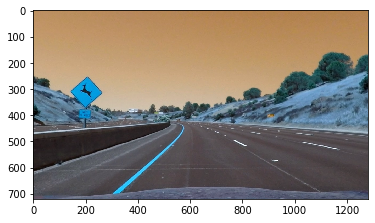

In [5]:


    
def findChessboardCorners(gray_cal_images,nx,ny,images_names,images):
    
    objpoints = [] #3D points in real world space
    imgpoints  = [] #2D points in image plan
    
    
    # prepare object points like (0,0,0),(1,0,0),(2,0,0).....(8,5,0)
    objp = np.zeros((6*9,3),np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    image_index = 0
    
    for gray_cal_image in gray_cal_images:
        
        #find chessboard corners in the image
        ret, corners = cv2.findChessboardCorners(gray_cal_image, (nx, ny), None)
        
        #If found, draw corners
        if ret == True:
            
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            img = cv2.drawChessboardCorners(images[image_index], (nx, ny), corners, ret)
            saveImage("./output_images/calibration_output/",images_names[image_index][:-4],img)
        
        image_index = image_index + 1
        
        
    return objpoints,imgpoints

def checkCalibrationData():
    exists = os.path.isfile('Calibration_data.p')
    
    return exists

def readCalibrationData():
    # Read in the saved objpoints and imgpoints
    dist_pickle = pickle.load( open( "Calibration_data.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
    return mtx,dist

def SaveCalibrationData(mtx,dist):
    
    dist_pickle = {}    
    
    if(mtx is not None) and (dist is not None):
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        pickle.dump(dist_pickle,open("Calibration_data.p","wb"))

def calibrateCamera(nx,ny):
    
    mtx = None
    dist = None

    camera_cal_exist = False
    
    camera_cal_exist = checkCalibrationData()
    
    if(camera_cal_exist is True):
        mtx,dist = readCalibrationData()
    
    if(camera_cal_exist is False) or (mtx is None) or (dist is None):

        #read calibration images
        cal_images_names,cal_images = readImages("camera_cal")

    
        gray_cal_images = convertImage(cal_images,cv2.COLOR_BGR2GRAY)
        
    
        if (gray_cal_images is not None) and (len(gray_cal_images) > 0):
                
            # Find the chessboard corners
            objpoints,imgpoints = findChessboardCorners(gray_cal_images,nx,ny,cal_images_names,cal_images)
        
            #imgpoints = np.array(imgpoints).astype('float32')
            img_size = (cal_images[0].shape[1],cal_images[0].shape[0])
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,img_size, None, None)
      
            #save the calibration    
            SaveCalibrationData(mtx,dist) 
        
    return  mtx, dist

def calibrateCamera_trial(nx,ny):
    
    mtx = None
    dist = None

    #read calibration images
    cal_images_names,cal_images = readImages("camera_cal")
    
    gray_cal_images = convertImage(cal_images,cv2.COLOR_BGR2GRAY)
        
    # Find the chessboard corners
    objpoints,imgpoints = findChessboardCorners(gray_cal_images,nx,ny,cal_images_names,cal_images)
        
    #imgpoints = np.array(imgpoints).astype('float32')
    img_size = (cal_images[0].shape[1],cal_images[0].shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,img_size, None, None)
        
    return  mtx, dist
    
def measureCurvaturePixels(left_fit,right_fit,ploty):
    
    # Calculates the curvature of polynomial functions in pixels.
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad



     
    
def undistortImage(image,mtx,dist,save_image,save_path,image_name):    
    
    undistorted_image = cv2.undistort(image, mtx, dist,None)
    
    #save the undistorted image
    if(save_image is True):
            saveImage("./output_images/undistortion_output",image_name,undistorted_image)
    
   
    return undistorted_image

#Test the function and plot the image

#caibrate the camera
#nx and ny are the numer of intersections between white and black
image_trial =  cv2.imread('test_images/test2.jpg')

nx_trial = 9
ny_trial = 6
mtx_trial, dist_trial = calibrateCamera_trial(nx_trial,ny_trial)
undistorted_image_trial = undistortImage(image_trial,mtx_trial,dist_trial,None,None,None)
plt.imshow(undistorted_image_trial)


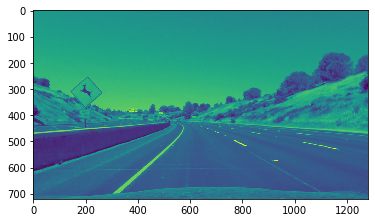

In [6]:
gray_image_trial = convertImage(undistorted_image_trial,cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image_trial)

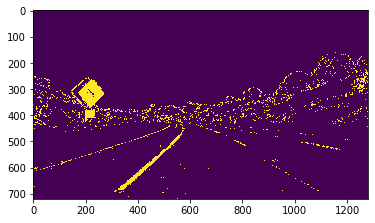

In [7]:
def absSobelThresh(gray_image,sobel_kernel,orientaion):
        
    #Calculate the derivative in the xx direction (the 1, 0 at the end denotes xx direction)
    if orientaion == 'x':
        sobelx = cv2.Sobel(gray_image,cv2.CV_64F,1,0,ksize = sobel_kernel)
        abs_sobel_thresh = np.absolute(sobelx)
        
    elif orientaion == 'y':
        sobely = cv2.Sobel(gray_image,cv2.CV_64F,0,1,ksize = sobel_kernel)
        abs_sobel_thresh = np.absolute(sobely)
    else:
        abs_sobel_thresh = None
        
    return abs_sobel_thresh

def createBinaryImage(gradient,min_threshold,max_threshold):
    
    #create zeros vector with the size of gradient
    grad_binary_image = np.zeros_like(gradient)
    
    #set the pixels that more than min threshold and less than max_threshold with 1
    grad_binary_image[(gradient >= min_threshold) & (gradient <= max_threshold)] = 1
    

    return grad_binary_image

def magnitudeThresh(gray_image,abs_sobelx,abs_sobely,mag_thresh_min,mag_thresh_max):
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(abs_sobelx**2,abs_sobely**2)
    
    #Convert the absolute value image to 8-bit
    scaled_gradmag = np.uint8(255 * gradmag/np.max(gradmag))
    
    mag_binary_image = createBinaryImage(scaled_gradmag,mag_thresh_min,mag_thresh_max)

    return mag_binary_image
    
def dirThreshold(gray_image,abs_sobelx,abs_sobely,dir_min_threshold,dir_max_threshold):
    
    # Calculate gradient direction
    # Apply threshold
    graddir = np.arctan2(abs_sobely,abs_sobelx)
    
    dir_binary_image = createBinaryImage(graddir,dir_min_threshold,dir_max_threshold)
                    
    return dir_binary_image

def combineMagDirThresholds(mag_binary_image,dir_binary_image,abs_sobelx,abs_sobely):
    
    combined_binary_image = np.zeros_like(dir_binary_image)
    
    combined_binary_image[(abs_sobelx == 1) & (abs_sobely == 1) | ((mag_binary_image == 1) & (dir_binary_image == 1))] = 1
    
    return combined_binary_image
    

def applyMagDirThresholds(gray_image,sobel_kernel,mag_min_thresh,mag_max_thresh,dir_min_thresh,dir_max_thresh,save_image,save_path,image_name):
    
    #apply Sobel threshold
    abs_sobelx = absSobelThresh(gray_image,sobel_kernel,'x')
    abs_sobely = absSobelThresh(gray_image,sobel_kernel,'y')
    
    #apply magnitude Threshold
    mag_threshold_binary_image = magnitudeThresh(gray_image,abs_sobelx,abs_sobely,mag_min_thresh,mag_max_thresh)
    
    #apply direction threshold
    dir_threshold_binary_image = dirThreshold(gray_image,abs_sobelx,abs_sobely,dir_min_thresh,dir_max_thresh)
    
    #combine the magnitude and direction thresholds into 1 threshold
    combined_mag_dir_binary_image = combineMagDirThresholds(mag_threshold_binary_image,dir_threshold_binary_image,dir_min_thresh,dir_max_thresh)
    
    #save the undistorted image
    if(save_image is True):
        mag_dir_example_image = combined_mag_dir_binary_image *255
        saveImage("./output_images/gradient/mag_dir",image_name,mag_dir_example_image)
        
    
    return combined_mag_dir_binary_image



def applyColorThreshold(original_image,s_min_threshold,s_max_threshold):
    
    hls_image = convertImage(original_image,cv2.COLOR_BGR2HLS)
    
    s_channel_image = hls_image[:,:,2]

    color_gradient_binary_output = createBinaryImage(s_channel_image,s_min_threshold,s_max_threshold)
    
    return color_gradient_binary_output


def applyDifferentGradients(image,gray_image,save_image,save_path,image_name):
    
    combined_mag_dir_binary_image = applyMagDirThresholds(gray_image,3,30,100,0,np.pi/2,save_image,save_path,image_name)
    
    color_threshold_binary_image = applyColorThreshold(image,170,255)
    
    
    combined_mag_dir_color_image = np.zeros_like(combined_mag_dir_binary_image)
    combined_mag_dir_color_image[(combined_mag_dir_binary_image == 1) | (color_threshold_binary_image == 1)] = 1
    
    #color_binary = np.dstack(( np.zeros_like(combined_mag_dir_binary_image), combined_mag_dir_binary_image, color_threshold_binary_image)) * 255
    
    if(save_image is True):
        all_gradients_example = combined_mag_dir_color_image*255
        saveImage(str(save_path)+"/gradient/color_mag_dir",image_name,all_gradients_example)
        
    return combined_mag_dir_color_image


#apply gradients
combined_mag_dir_color_image_trial = applyDifferentGradients(image_trial,gray_image_trial,None,None,None)

plt.imshow(combined_mag_dir_color_image_trial)


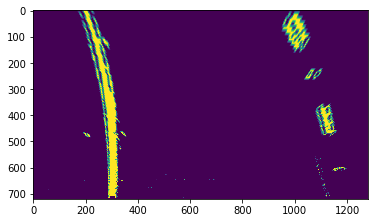

In [8]:
def GetBirdEyeView(gradient_binary_image,save_image,save_path,image_name):
    
    
    h, w = gradient_binary_image.shape[:2]
    
    # This should be chosen to present the result at the proper aspect ratio
    # My choice of 100 pixels is not exact, but close enough for our purpose here
    # offset for dst points
    offset = 100
    
    src = np.float32([[w, h-10],    # br
                      [0, h-10],    # bl
                      [(w/2) - offset, (h/2) + offset],   # tl
                      [(w/2) + offset, (h/2) + offset] ])  # tr
    
    dst = np.float32([[w, h],       # br
                      [0, h],       # bl
                      [0, 0],       # tl
                      [w, 0] ])      # tr

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)

    Bird_eye_view_binary = cv2.warpPerspective(gradient_binary_image, M, (w, h), flags=cv2.INTER_LINEAR)
    
    if(save_image is True):
        bird_eye_example = Bird_eye_view_binary*255
        saveImage(str(save_path)+"/bird_eye_output",image_name,bird_eye_example)
    
    return Bird_eye_view_binary,Minv

bird_eye_binary_image_trial,Minv_trial = GetBirdEyeView(combined_mag_dir_color_image_trial,None,None,None)

plt.imshow(bird_eye_binary_image_trial)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


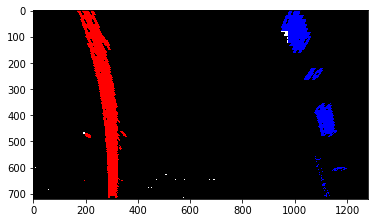

In [9]:

def getHist(binary_warped_image):
    
    height = binary_warped_image.shape[0]
    
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = binary_warped_image[height//2:,:]

    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half,axis = 0)
    

    return histogram


def findLanesPixels(binary_warped,nwindows,margin,minpix):
    
    #get the histogram of the image
    histogram = getHist(binary_warped)
    
    #get the height
    image_height = binary_warped.shape[0]
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    

    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(image_height//2)
    
    right_side_values = histogram[midpoint:]
    
    left_side_values = histogram[:midpoint]
    
    #find the index where there is maximum pixel value starting from beginning to the mid point
    leftx_base = np.argmax(left_side_values)
    
    #find the index where there is maximum pixel value starting from the mid point till the end of histogram
    rightx_base = np.argmax(right_side_values) + midpoint
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(image_height//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    
    #get the coulmn indicies that doesn't contain zeros
    nonzeroy = np.array(nonzero[0])
    
     #get the row indicies that doesn't contain zeros
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image_height - (window+1)*window_height  #720 - 80
        win_y_high = image_height - window*window_height  #720 
        
        #Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the window on left line
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)        
        #draw the window on the right line
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        #Identify the nonzero pixels in x and y within the window
        #mark the left pixels that are within the valid range
        good_left = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high))
        
        #get the y indicies that contains True values
        good_left_inds = good_left.nonzero()[0]
        
        #mark the left pixels that are within the valid range
        good_right = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high))
        
        #get the y indicies that contains True values
        good_right_inds = good_right.nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            #get the indicies values of the wraped image
            good_left_indicies_wraped = nonzerox[good_left_inds]
            #get the middle index of them
            leftx_current = np.int(np.mean(good_left_indicies_wraped))
        if len(good_right_inds) > minpix:
            #get the indicies values of the wraped image
            good_right_indicies_wraped = nonzerox[good_right_inds]
            #get the middle index of them
            rightx_current = np.int(np.mean(good_right_indicies_wraped))
            

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        #convert multiple lists into 1 big array
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass


    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fitPolynomial(binary_warped_img_shape, leftx, lefty, rightx, righty):
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped_img_shape[0]-1, binary_warped_img_shape[0])
   
    #Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit,right_fit,left_fitx, right_fitx, ploty    

def fitCurvatureUsingSlidingWindow(binary_warped_image,nwindows,margin,minpix):
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = findLanesPixels(binary_warped_image,nwindows,margin,minpix)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit,right_fit,left_fitx, right_fitx, ploty = fitPolynomial(binary_warped_image.shape, leftx, lefty, rightx, righty)

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
        
        
    return left_fit,right_fit,ploty,left_fitx,right_fitx,out_img



def fitCurvatureUsingPreviousPoly(binary_warped,left_fit,right_fit):
    
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit,right_fit,left_fitx, right_fitx, ploty = fitPolynomial(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    curved_binary_image = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
    return left_fit,right_fit,ploty,left_fitx,right_fitx,curved_binary_image

def findCurvatures(bird_eye_binary_image,nwindows,margin,minpix):

    global left_fit,right_fit
    
    global first_frame
    if first_frame is True:    
        left_fit,right_fit,ploty,left_fitx,right_fitx,curved_binary_image = fitCurvatureUsingSlidingWindow(bird_eye_binary_image,nwindows,margin,minpix)
        first_frame = False
    else:
        left_fit,right_fit,ploty,left_fitx,right_fitx,curved_binary_image = fitCurvatureUsingPreviousPoly(bird_eye_binary_image,left_fit,right_fit)
        
    return ploty,left_fitx,right_fitx,curved_binary_image
        

    
# HYPERPARAMETERS
# Choose the number of sliding windows
nwindows_trial = 9
# Set the width of the windows +/- margin
margin_trial = 100
# Set minimum number of pixels found to recenter window
minpix_trial = 50
global first_frame
first_frame = True
ploty_trial,left_fitx_trial,right_fitx_trial,curved_binary_image_trial = findCurvatures(bird_eye_binary_image_trial,nwindows_trial,margin_trial,minpix_trial)
plt.imshow(curved_binary_image_trial)
first_frame = True

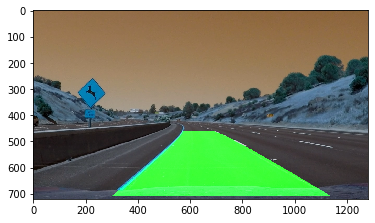

In [10]:
def insertAreaBetweenLanes(left_fitx,right_fitx,ploty,road_warp):

    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

 
    # Draw the lane onto the warped blank image
    cv2.fillPoly(road_warp,np.int_([pts]),(0,255, 0))
    

        

def alignLanesWithImage(road_warp,Minv,curved_binary_image,image):

    restored_curved_binary_image = cv2.warpPerspective(road_warp,Minv,(curved_binary_image.shape[1],curved_binary_image.shape[0]))
    restored_curved_binary_image = restored_curved_binary_image.astype(np.uint8)
    
    final_image = weighted_img(restored_curved_binary_image,image, 0.8, 1, 0)
    
    return final_image


def insertLanesAreaonImage(image,undistorted_image,curved_binary_image,left_fitx,right_fitx,ploty,Minv):
    
    # Create an image to draw the lines on
    road_warp  = np.zeros_like(undistorted_image,dtype=np.uint8)
    
    #Draw the green area between lanes
    insertAreaBetweenLanes(left_fitx,right_fitx,ploty,road_warp)
    
    lanes_inserted_image = alignLanesWithImage(road_warp,Minv,curved_binary_image,image)
    
    return lanes_inserted_image
        
    
lanes_inserted_image_trial = insertLanesAreaonImage(image_trial,undistorted_image_trial,curved_binary_image_trial,left_fitx_trial,right_fitx_trial,ploty_trial,Minv_trial)

plt.imshow(lanes_inserted_image_trial)

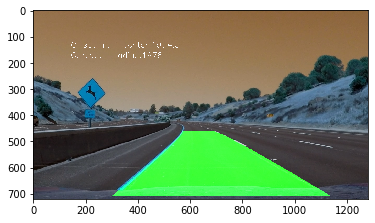

In [11]:
def measureCurvatureReal(ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
  # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

def putRadiusAndOffset(image,radius,offset):
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, "Curvature radius:"+str(radius),(np.int_(image.shape[0]/5),np.int_(image.shape[1]/7)),font,1.0,(255,255,255)) 
    cv2.putText(image, "Offset from center:"+str(offset),(np.int_(image.shape[0]/5),np.int_(image.shape[1]/9)),font,1.0,(255,255,255)) 
    return image

global left_fit,right_fit

left_curverad_real_trial, right_curverad_real_trial = measureCurvatureReal(ploty_trial,left_fit,right_fit)
    
radius_trial = np.int_(np.mean([left_curverad_real_trial,right_curverad_real_trial]))
    
    
offset_trial = radius_trial - 3.7
    
final_image_trial = putRadiusAndOffset(lanes_inserted_image_trial,radius_trial,offset_trial)
plt.imshow(final_image_trial)

In [ ]:


def processImage(image,save_image = False,save_path = None,full_image_name = None):

    global mtx,dist
    

    
    final_image = None
    
    if save_image is True:
        #remove the extention part
        image_name = full_image_name[:-4]
    else:
        image_name = None
        
    undistorted_image = undistortImage(image,mtx,dist,save_image,save_path,image_name)
    
    gray_image = convertImage(undistorted_image,cv2.COLOR_BGR2GRAY)
    
    #apply gradients
    combined_mag_dir_color_image = applyDifferentGradients(image,gray_image,save_image,save_path,image_name)
    
    
    #transform binary image to bird view image
    bird_eye_binary_image,Minv = GetBirdEyeView(combined_mag_dir_color_image,save_image,save_path,image_name)
    


    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    ploty,left_fitx,right_fitx,curved_binary_image = findCurvatures(bird_eye_binary_image,nwindows,margin,minpix)
    
    lanes_inserted_image = insertLanesAreaonImage(image,undistorted_image,curved_binary_image,left_fitx,right_fitx,ploty,Minv)
    
    left_curverad_real, right_curverad_real = measureCurvatureReal(ploty,left_fit,right_fit)
    
    radius = np.int_(np.mean([left_curverad_real,right_curverad_real]))
    
    
    offset = radius - 3.7
    
    final_image = putRadiusAndOffset(lanes_inserted_image,radius,offset)
    

    if(save_image is True):
        saveImage(str(save_path)+"/final_image",image_name+"binary_",curved_binary_image)
        saveImage(str(save_path)+"/final_image",image_name,final_image)
        
    
    return final_image


def ProcessTestImages(test_images_list,test_images_names):
    
    final_processed_images = []
    #global first_frame
    
    
    
    if(test_images_list is not None) and (len(test_images_list) > 0):
        for test_image_name,test_image in zip(test_images_names,test_images_list):
            first_frame = True
            final_image = processImage(test_image,True,"output_images",test_image_name)
            final_processed_images.append(final_image)
    
    return final_processed_images


def processTestVideos(videos_path):
    
    #convert video to images
    test_images_list = None
    
    global first_frame
    
    #select the source folder for calibration images
    videos_names = os.listdir(str(videos_path))
    
    for video_name in videos_names:
    
        clip = VideoFileClip(str(videos_path)+"/"+str(video_name))
        first_frame = True
        white_clip = clip.fl_image(processImage) #NOTE: this function expects color images!!
        white_clip.write_videofile("test_videos_output/"+str(video_name), audio=False)


def pipeline():

    global mtx,dist
    #caibrate the camera
    #nx and ny are the numer of intersections between white and black
    nx = 9
    ny = 6
    mtx, dist = calibrateCamera(nx,ny)
    
    test_images_names,test_images_list = readImages("test_images")  
    ProcessTestImages(test_images_list,test_images_names)
    #print(test_images_list)
    
    processTestVideos("test_videos")
    

pipeline()


Moviepy - Building video test_videos_output/challenge_video.mp4.
Moviepy - Writing video test_videos_output/challenge_video.mp4



t:  24%|████████████████▎                                                  | 118/485 [00:29<01:25,  4.30it/s, now=None]